Notebook programmed to detect colors in images from different input sources. 

In [ ]:
import numpy as np
import cv2
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from google.colab.patches import cv2_imshow

# Webcam's Module

## Helper Functions

In [ ]:
# Function to convert JavaScript objects into OpenCV images
def js_to_image(js_reply):

  # Decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])

  # Convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype = np.uint8)

  # Decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags = 1)

  return img

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  data = eval_js('takePhoto({})'.format(quality))

  # put data in opencv format
  img = js_to_image(data)

  # color detection
  result = color_detection(img)

  # save image
  cv2.imwrite(filename, result)
  
  return filename

# Color Detection Module

In [ ]:
# Define red range
lower_red = np.array([161, 155, 84])
upper_red = np.array([179, 255, 255])

# Define blue range
lower_blue = np.array([94, 80, 2])
upper_blue = np.array([126,255,255])

# Define green range
lower_green = np.array([25, 52, 72])
upper_green = np.array([102, 255, 255])

# Every color except white range
lower = np.array([0, 42, 0])
upper = np.array([179, 255, 255])

In [ ]:
def color_detection(image):
  hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) 

  # Define masks
  red_mask = cv2.inRange(hsv_img, lower_red, upper_red)
  blue_mask = cv2.inRange(hsv_img, lower_blue, upper_blue)
  green_mask = cv2.inRange(hsv_img, lower_green, upper_green)
  mask = cv2.inRange(hsv_img, lower, upper)
  total_mask = red_mask + blue_mask + green_mask


  # Apply color filtering
  red = cv2.bitwise_and(image, image, mask = red_mask)
  blue = cv2.bitwise_and(image, image, mask = blue_mask)
  green = cv2.bitwise_and(image, image, mask = green_mask)
  result = cv2.bitwise_and(image, image, mask = mask)
  total = cv2.bitwise_and(image, image, mask = total_mask)
  
  final_img = red

  return final_img

## In photos

<IPython.core.display.Javascript object>

Saved to photo.jpg


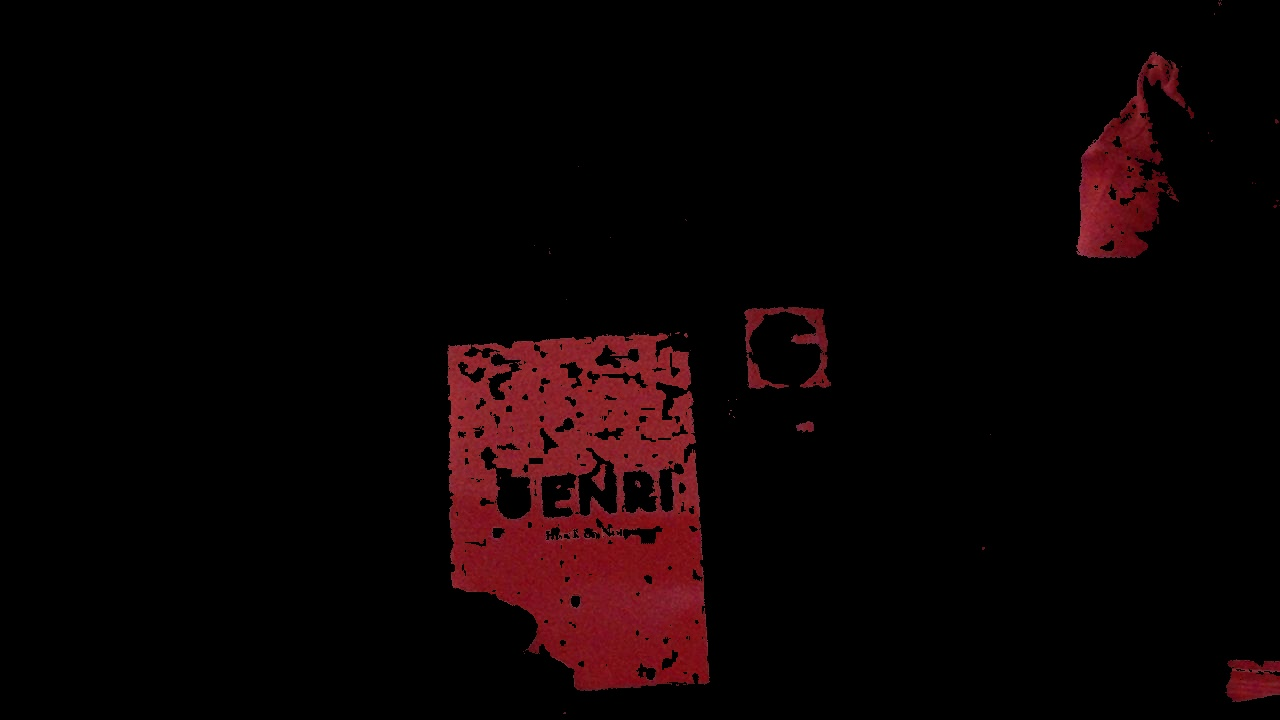

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## In videos

Configuration of the webcam to record videos

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label):
  data = eval_js('stream_frame("{}")'.format(label))
  return data

Color detection with the webcam input

In [1]:
from IPython.display import clear_output 

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
label_mask = 'Blue mask...'
# initialze bounding box to empty
while True:
    js_reply = video_frame(label_html)
    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])
    result = color_detection(img)
    cv2.imwrite(filename, result)
    display(Image(filename))
    clear_output()


NameError: ignored

<IPython.core.display.Javascript object>

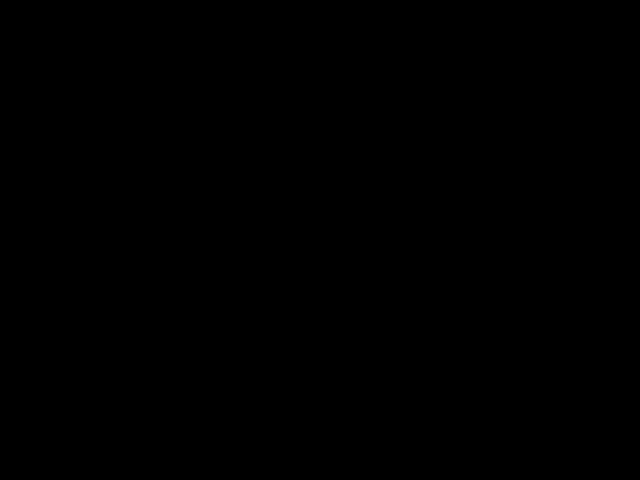

In [ ]:
from IPython.display import Image

video_stream()
label_mask = 'Blue mask...'
js_reply = video_frame(label_mask)
img = js_to_image(js_reply['img'])
result = color_detection(img)
# Show the image which was just taken.
